In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import pandas as pd
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
image_path=[]
labels=[]
for i in os.listdir("C:/Users/nihal/Downloads/archive/afhq"):
    for label in os.listdir(f"C:/Users/nihal/Downloads/archive/afhq/{i}"):
        for img in os.listdir(f"C:/Users/nihal/Downloads/archive/afhq/{i}/{label}"):
            image_path.append(f"C:/Users/nihal/Downloads/archive/afhq/{i}/{label}/{img}")
            labels.append(label)
data_df=pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])
print(data_df['labels'].unique())
print(data_df.head())

['cat' 'dog' 'wild']
                                          image_path labels
0  C:/Users/nihal/Downloads/archive/afhq/train/ca...    cat
1  C:/Users/nihal/Downloads/archive/afhq/train/ca...    cat
2  C:/Users/nihal/Downloads/archive/afhq/train/ca...    cat
3  C:/Users/nihal/Downloads/archive/afhq/train/ca...    cat
4  C:/Users/nihal/Downloads/archive/afhq/train/ca...    cat


In [3]:
train=data_df.sample(frac=0.7)
test=data_df.drop(train.index)
val=test.sample(frac=0.5)
test=test.drop(val.index)
print(f"Train shape: {train.shape}")
print(f"Val shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (11291, 2)
Val shape: (2420, 2)
Test shape: (2419, 2)


In [4]:
label_encoder=LabelEncoder()
label_encoder.fit(data_df['labels'])
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])  

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe=dataframe
        self.transform=transform
        self.labels=torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self,idx):
        img_path=self.dataframe.iloc[idx,0]
        label=self.labels[idx]

        image=Image.open(img_path).convert("RGB")

        if self.transform:
            image=self.transform(image).to(device)
            
        return image,label

In [6]:
train_dataset=CustomImageDataset(dataframe=train,transform=transform)
val_dataset=CustomImageDataset(dataframe=val,transform=transform)
test_dataset=CustomImageDataset(dataframe=test,transform=transform)

In [7]:
train_dataset.__getitem__(2)

(tensor([[[0.6627, 0.6627, 0.6667,  ..., 0.8353, 0.8353, 0.8275],
          [0.6706, 0.6667, 0.6627,  ..., 0.8275, 0.8157, 0.8157],
          [0.6745, 0.6667, 0.6588,  ..., 0.8078, 0.8118, 0.8157],
          ...,
          [0.8157, 0.8196, 0.8235,  ..., 0.4745, 0.5294, 0.4863],
          [0.8196, 0.8196, 0.8196,  ..., 0.4863, 0.5216, 0.5373],
          [0.8157, 0.8157, 0.8196,  ..., 0.5333, 0.5098, 0.5098]],
 
         [[0.5608, 0.5608, 0.5608,  ..., 0.7843, 0.7843, 0.7765],
          [0.5608, 0.5647, 0.5686,  ..., 0.7765, 0.7647, 0.7647],
          [0.5647, 0.5725, 0.5725,  ..., 0.7569, 0.7608, 0.7647],
          ...,
          [0.7765, 0.7804, 0.7843,  ..., 0.3137, 0.3608, 0.3137],
          [0.7804, 0.7804, 0.7804,  ..., 0.3451, 0.3804, 0.3843],
          [0.7765, 0.7765, 0.7804,  ..., 0.4196, 0.4039, 0.3882]],
 
         [[0.4471, 0.4392, 0.4549,  ..., 0.7216, 0.7216, 0.7137],
          [0.4627, 0.4510, 0.4510,  ..., 0.7137, 0.7020, 0.7020],
          [0.4549, 0.4471, 0.4588,  ...,

In [8]:
label_encoder.inverse_transform([1])

array(['dog'], dtype=object)

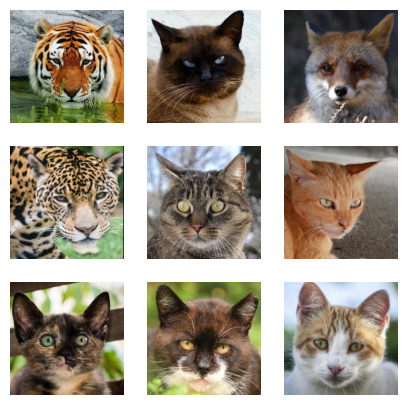

In [9]:
n_rows=3
n_cols=3
fig,ax=plt.subplots(n_rows,n_cols,figsize=(5,5))

for row in range(n_rows):
    for col in range(n_cols):
        image=Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        ax[row,col].imshow(image)
        ax[row,col].axis("off")
plt.show()
        

In [10]:
lr=0.001
batch_size=16
Epochs=10

In [11]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.pooling=nn.MaxPool2d(2,2)
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.linear=nn.Linear((128*16*16),128)
        self.output=nn.Linear(128,len(data_df['labels'].unique()))

    def forward(self,x):
        x=self.conv1(x)
        x=self.pooling(x)
        x=self.relu(x)
        
        x=self.conv2(x)
        x=self.pooling(x)
        x=self.relu(x)

        x=self.conv3(x)
        x=self.pooling(x) 
        x=self.relu(x)

        x=self.flatten(x)
        x=self.linear(x)
        x=self.output(x)
        return x

In [13]:
model=CNNModel().to(device)

In [14]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [15]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=lr)

In [16]:
total_train_loss_plot=[]    
total_val_loss_plot=[]
total_train_acc_plot=[]
total_val_acc_plot=[] 

for epoch in range(Epochs):
    total_train_loss=0
    total_val_loss=0
    total_train_acc=0
    total_val_acc=0

    for inputs,labels in train_loader:
        optimizer.zero_grad()

        outputs=model(inputs)
        loss=criterion(outputs,labels)
        total_train_loss+=loss.item()
        loss.backward()

        acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
        total_train_acc+=acc

        optimizer.step()
    
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs=model(inputs)
            vloss=criterion(outputs,labels)
            total_val_loss+=vloss.item()

            vacc=(torch.argmax(outputs,axis=1)==labels).sum().item()
            total_val_acc+=vacc
    total_train_loss_plot.append(round(total_train_loss/1000,4))
    total_val_loss_plot.append(round(total_val_loss/1000,4))
    total_train_acc_plot.append(round((total_train_acc/train_dataset.__len__())*100,4))
    total_val_acc_plot.append(round((total_val_acc/val_dataset.__len__())*100,4))

    print(f"Epoch: {epoch+1}/{Epochs}, Train Loss: {round(total_train_loss/1000,4)}, Val Loss: {round(total_val_loss/1000,4)}, Train Acc: {round((total_train_acc/train_dataset.__len__())*100,4)}%, Val Acc: {round((total_val_acc/val_dataset.__len__())*100,4)}%")


        

Epoch: 1/10, Train Loss: 0.2873, Val Loss: 0.028, Train Acc: 83.2079%, Val Acc: 93.719%
Epoch: 2/10, Train Loss: 0.1002, Val Loss: 0.0179, Train Acc: 94.8809%, Val Acc: 96.0744%
Epoch: 3/10, Train Loss: 0.0605, Val Loss: 0.0208, Train Acc: 96.9533%, Val Acc: 95.6612%
Epoch: 4/10, Train Loss: 0.0462, Val Loss: 0.0187, Train Acc: 97.6176%, Val Acc: 95.5785%
Epoch: 5/10, Train Loss: 0.0334, Val Loss: 0.0214, Train Acc: 98.3881%, Val Acc: 95.7438%
Epoch: 6/10, Train Loss: 0.0318, Val Loss: 0.0159, Train Acc: 98.2375%, Val Acc: 96.7769%
Epoch: 7/10, Train Loss: 0.0254, Val Loss: 0.0237, Train Acc: 98.6361%, Val Acc: 96.1157%
Epoch: 8/10, Train Loss: 0.0206, Val Loss: 0.0228, Train Acc: 98.8575%, Val Acc: 96.157%
Epoch: 9/10, Train Loss: 0.0199, Val Loss: 0.0219, Train Acc: 99.0523%, Val Acc: 96.6116%
Epoch: 10/10, Train Loss: 0.011, Val Loss: 0.0372, Train Acc: 99.4775%, Val Acc: 95.8678%


In [17]:
with torch.no_grad():
    total_test_loss=0
    total_test_acc=0
    for inputs,labels in test_loader:
        outputs=model(inputs)
        tacc=(torch.argmax(outputs,axis=1)==labels).sum().item()
        total_test_acc+=tacc
        tloss=criterion(outputs,labels)
        total_test_loss+=tloss.item()
    print(f"Test Accuracy: {round((total_test_acc/test_dataset.__len__())*100,4)}%")

Test Accuracy: 96.3208%


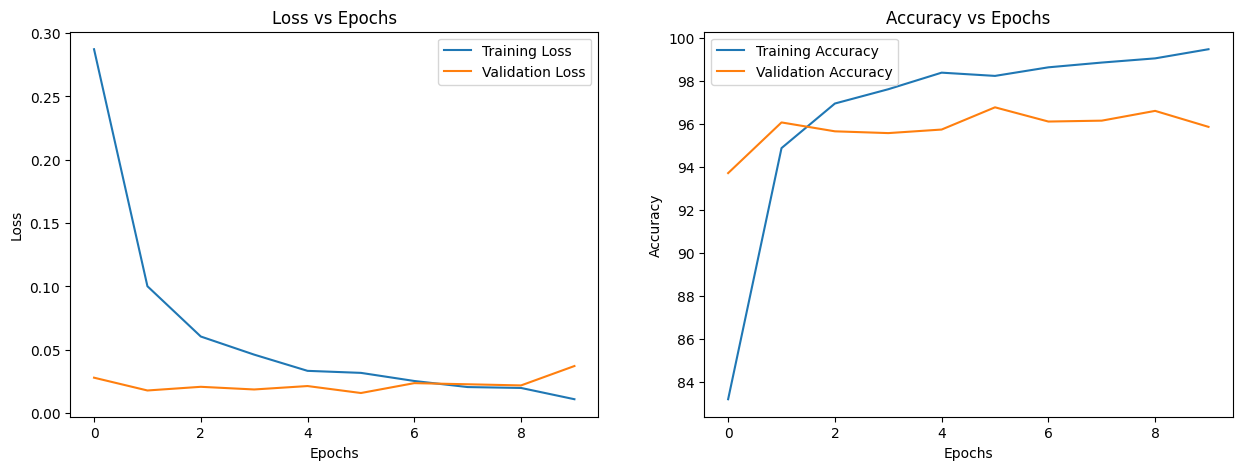

In [18]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(total_train_loss_plot,label="Training Loss")
ax[0].plot(total_val_loss_plot,label="Validation Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(total_train_acc_plot,label="Training Accuracy")
ax[1].plot(total_val_acc_plot,label="Validation Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

FileUpload(value=(), accept='image/*', description='Upload')

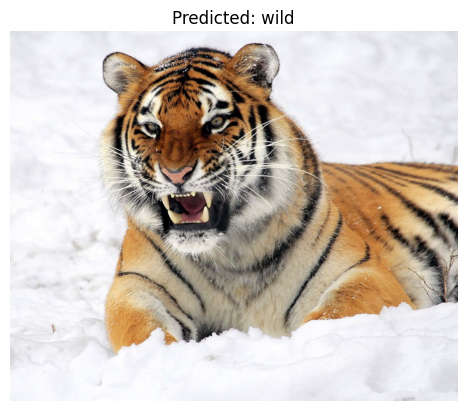

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import io

# Define transform (must match training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # adjust to your training size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # adjust if needed
])

def on_upload_change(change):
    for file_info in uploader.value:   # value is a tuple of dicts
        name = file_info['name']
        content = file_info['content']

        # Load image directly from memory (no saving)
        img = Image.open(io.BytesIO(content)).convert("RGB")

        # Show the image
        plt.imshow(img)
        plt.axis("off")

        # Preprocess
        img_t = transform(img).unsqueeze(0)
        model.eval()
        with torch.no_grad():
            output = model(img_t.to(next(model.parameters()).device))
            pred_idx = torch.argmax(output, dim=1).item()

        # Show prediction with image
        plt.title(f"Predicted: {classes[pred_idx]}")
        plt.show()

# Upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')
display(uploader)

# Example class labels
classes = ["cat", "dog", "wild"]  # replace with your actual dataset labels
